# NLP Fake News Detection - Preprocessing Comparison

**Goal:** Compare different preprocessing configurations to find optimal approach.

**Configurations to test:**

| # | Config | Encoding | Punctuation | Stopwords | Stem/Lemma | N-grams |
|---|--------|----------|-------------|-----------|------------|----------|
| 1 | Baseline | ✓ | ✓ | ✗ | ✗ | (1,2) |
| 2 | Manual stopwords | ✓ | ✓ | ✓ manual | ✗ | (1,2) |
| 3 | TF-IDF stopwords | ✓ | ✓ | ✓ TF-IDF | ✗ | (1,2) |
| 4 | Keep punctuation | ✓ | ✗ | ✗ | ✗ | (1,2) |
| 5 | Stemming | ✓ | ✓ | ✓ | Stemming | (1,2) |
| 6 | Lemmatization | ✓ | ✓ | ✓ | Lemmatization | (1,2) |
| 7 | Unigrams | ✓ | ✓ | ✗ | ✗ | (1,1) |
| 8 | Bigrams | ✓ | ✓ | ✗ | ✗ | (1,2) |
| 9 | Trigrams | ✓ | ✓ | ✗ | ✗ | (1,3) |

---
## 1. Setup & Data Loading

In [1]:
# Imports - only what we need
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK data (run once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
# Load data ONCE
df = pd.read_csv('training_data_lowercase.csv', sep='\t', header=None, names=['label', 'title'])
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['label'].value_counts()}")

Dataset shape: (34152, 2)
Class distribution:
label
0    17572
1    16580
Name: count, dtype: int64


---
## 2. Preprocessing Functions

In [3]:
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, 
                    fix_encoding=True,
                    remove_punctuation=True, 
                    remove_stopwords=False, 
                    use_stemming=False, 
                    use_lemmatization=False):
    """
    Configurable text preprocessing pipeline.
    
    Parameters:
    - fix_encoding: Fix tabs and apostrophe encoding
    - remove_punctuation: Remove punctuation marks
    - remove_stopwords: Remove common English words
    - use_stemming: Apply Porter stemming
    - use_lemmatization: Apply WordNet lemmatization
    """
    # Step 1: Fix encoding issues (always recommended)
    if fix_encoding:
        text = text.replace('\t', ' ')
        text = text.replace('\u201a', "'")  # single low-9 quote
        text = text.replace('\u2018', "'")  # left single quote
        text = text.replace('\u2019', "'")  # right single quote
    
    # Step 2: Remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Step 3: Tokenize (split into words)
    words = text.lower().split()
    
    # Step 4: Remove stopwords
    if remove_stopwords:
        words = [w for w in words if w not in stop_words]
    
    # Step 5: Stemming OR Lemmatization (not both)
    if use_stemming:
        words = [stemmer.stem(w) for w in words]
    elif use_lemmatization:
        words = [lemmatizer.lemmatize(w) for w in words]
    
    # Rejoin
    return ' '.join(words)

In [4]:
# Test preprocessing on a sample
sample = "Trump's AMAZING tax plan is the BEST; Democrats are very worried!"

print("Original:", sample)
print("\n1. Encoding fix only:      ", preprocess_text(sample, remove_punctuation=False))
print("2. + Punctuation removed:  ", preprocess_text(sample, remove_punctuation=True))
print("3. + Stopwords removed:    ", preprocess_text(sample, remove_stopwords=True))
print("4. + Stemming:             ", preprocess_text(sample, remove_stopwords=True, use_stemming=True))
print("5. + Lemmatization:        ", preprocess_text(sample, remove_stopwords=True, use_lemmatization=True))

Original: Trump's AMAZING tax plan is the BEST; Democrats are very worried!

1. Encoding fix only:       trump's amazing tax plan is the best; democrats are very worried!
2. + Punctuation removed:   trumps amazing tax plan is the best democrats are very worried
3. + Stopwords removed:     trumps amazing tax plan best democrats worried
4. + Stemming:              trump amaz tax plan best democrat worri
5. + Lemmatization:         trump amazing tax plan best democrat worried


---
## 3. Model Training Function

In [5]:
def run_experiment(df, config_name, description, preprocess_params, vectorizer_params):
    """
    Run a complete experiment with given preprocessing and vectorizer settings.
    
    Returns: dict with results
    """
    print(f"\n{'='*70}")
    print(f"Config: {config_name}")
    print(f"Settings: {description}")
    print(f"{'='*70}")
    
    # Step 1: Apply preprocessing
    print("Preprocessing...")
    df_exp = df.copy()
    df_exp['title_processed'] = df_exp['title'].apply(
        lambda x: preprocess_text(x, **preprocess_params)
    )
    
    # Step 2: Train/test split
    X = df_exp['title_processed']
    y = df_exp['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # Step 3: Vectorize
    print("Vectorizing...")
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    print(f"Feature count: {X_train_tfidf.shape[1]}")
    
    # Step 4: Train model
    print("Training Logistic Regression...")
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train_tfidf, y_train)
    
    # Step 5: Evaluate
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n>>> ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%) <<<")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Return results
    return {
        'config': config_name,
        'description': description,
        'accuracy': accuracy,
        'model': model,
        'vectorizer': vectorizer,
        'preprocess_params': preprocess_params,
        'vectorizer_params': vectorizer_params,
        'y_test': y_test,
        'y_pred': y_pred
    }

---
## 4. Define Experiment Configurations

**Legend:**
- ✓ = Applied
- ✗ = Not applied
- Encoding = Fix tabs + apostrophe encoding
- Punctuation = Remove punctuation marks
- Stopwords = Remove common words (manual or via TF-IDF)
- Stem/Lemma = Word normalization

In [6]:
# Base vectorizer settings
base_vectorizer_params = {
    'min_df': 2,
    'max_df': 0.9,
    'ngram_range': (1, 2)
}

# ============================================================
# EXPERIMENT CONFIGURATIONS
# Format: [Encoding | Punctuation | Stopwords | Stem/Lemma | N-grams]
# ============================================================

experiments = [
    
    # ---------- BASELINE ----------
    {
        'name': '1. Baseline',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | Bigrams (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': False,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2)}
    },
    
    # ---------- STOPWORDS EXPERIMENTS ----------
    {
        'name': '2. Manual stopword removal',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✓ MANUAL | Stem/Lemma ✗ | Bigrams (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': True,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2)}
    },
    {
        'name': '3. TF-IDF stopword removal',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✓ TF-IDF | Stem/Lemma ✗ | Bigrams (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': False,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2), 'stop_words': 'english'}
    },
    
    # ---------- PUNCTUATION EXPERIMENT ----------
    {
        'name': '4. Keep punctuation',
        'description': 'Encoding ✓ | Punctuation ✗ KEPT | Stopwords ✗ | Stem/Lemma ✗ | Bigrams (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': False,
            'remove_stopwords': False,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2)}
    },
    
    # ---------- STEMMING / LEMMATIZATION ----------
    {
        'name': '5. With stemming',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✓ | STEMMING ✓ | Bigrams (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': True,
            'use_stemming': True,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2)}
    },
    {
        'name': '6. With lemmatization',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✓ | LEMMATIZATION ✓ | Bigrams (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': True,
            'use_stemming': False,
            'use_lemmatization': True
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2)}
    },
    
    # ---------- N-GRAM EXPERIMENTS ----------
    {
        'name': '7. Unigrams only',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | UNIGRAMS (1,1)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': False,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 1)}
    },
    {
        'name': '8. Bigrams',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | BIGRAMS (1,2)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': False,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 2)}
    },
    {
        'name': '9. Trigrams',
        'description': 'Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | TRIGRAMS (1,3)',
        'preprocess': {
            'fix_encoding': True,
            'remove_punctuation': True,
            'remove_stopwords': False,
            'use_stemming': False,
            'use_lemmatization': False
        },
        'vectorizer': {**base_vectorizer_params, 'ngram_range': (1, 3)}
    },
]

print(f"Total configurations to test: {len(experiments)}")

Total configurations to test: 9


---
## 5. Run All Experiments

In [7]:
# Run all experiments and collect results
results = []

for exp in experiments:
    result = run_experiment(
        df=df,
        config_name=exp['name'],
        description=exp['description'],
        preprocess_params=exp['preprocess'],
        vectorizer_params=exp['vectorizer']
    )
    results.append(result)


Config: 1. Baseline
Settings: Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | Bigrams (1,2)
Preprocessing...
Train size: 27321, Test size: 6831
Vectorizing...
Feature count: 50624
Training Logistic Regression...

>>> ACCURACY: 0.9460 (94.60%) <<<

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3529
           1       0.93      0.96      0.94      3302

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831


Config: 2. Manual stopword removal
Settings: Encoding ✓ | Punctuation ✓ | Stopwords ✓ MANUAL | Stem/Lemma ✗ | Bigrams (1,2)
Preprocessing...
Train size: 27321, Test size: 6831
Vectorizing...
Feature count: 38426
Training Logistic Regression...

>>> ACCURACY: 0.9344 (93.44%) <<<

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.9

---
## 6. Compare Results

In [8]:
# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Configuration': r['config'],
        'Settings': r['description'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Accuracy %': f"{r['accuracy']*100:.2f}%"
    }
    for r in results
])

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*100)
print("RESULTS SUMMARY (sorted by accuracy)")
print("="*100)
print(comparison_df.to_string(index=False))


RESULTS SUMMARY (sorted by accuracy)
             Configuration                                                                       Settings Accuracy Accuracy %
          7. Unigrams only       Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | UNIGRAMS (1,1)   0.9463     94.63%
               9. Trigrams       Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | TRIGRAMS (1,3)   0.9461     94.61%
               1. Baseline        Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | Bigrams (1,2)   0.9460     94.60%
       4. Keep punctuation   Encoding ✓ | Punctuation ✗ KEPT | Stopwords ✗ | Stem/Lemma ✗ | Bigrams (1,2)   0.9460     94.60%
                8. Bigrams        Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | BIGRAMS (1,2)   0.9460     94.60%
          5. With stemming          Encoding ✓ | Punctuation ✓ | Stopwords ✓ | STEMMING ✓ | Bigrams (1,2)   0.9363     93.63%
3. TF-IDF stopword removal Encoding ✓ | Punctuation ✓ | Stopwords ✓ TF-IDF | Ste

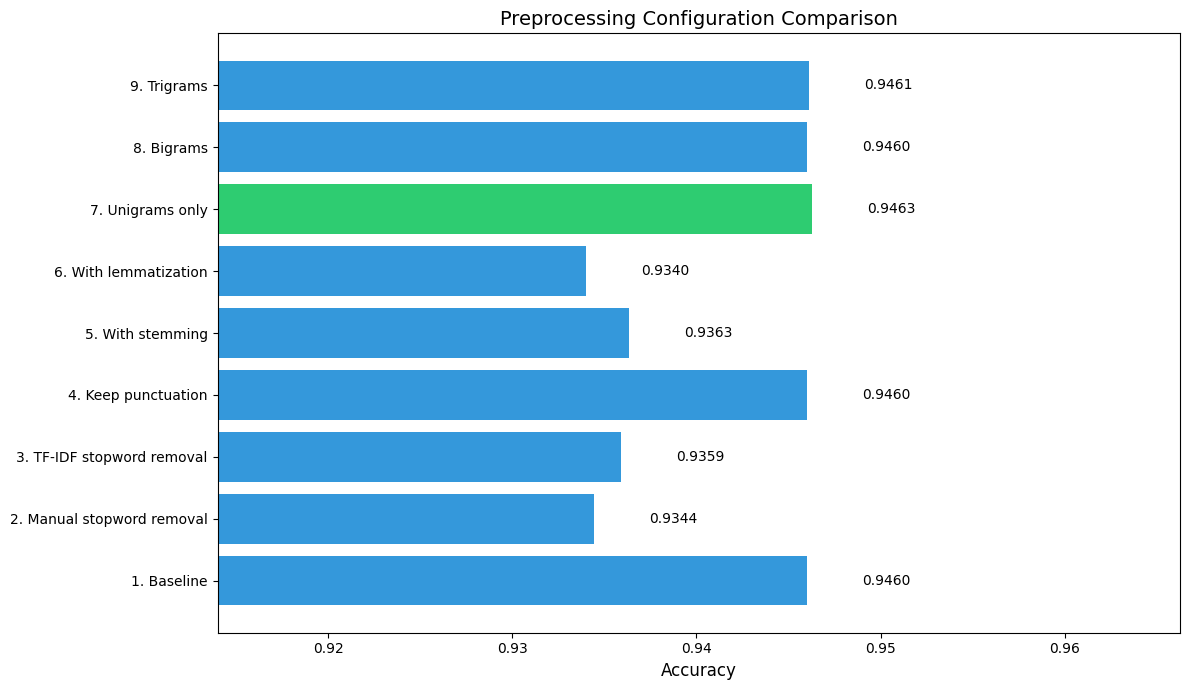

In [9]:
# Visualize comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))

# Get data
configs = [r['config'] for r in results]
accuracies = [r['accuracy'] for r in results]

# Create horizontal bar chart
colors = ['#2ecc71' if acc == max(accuracies) else '#3498db' for acc in accuracies]
bars = ax.barh(configs, accuracies, color=colors)

ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Preprocessing Configuration Comparison', fontsize=14)
ax.set_xlim(min(accuracies) - 0.02, max(accuracies) + 0.02)  # Zoom in on relevant range

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(acc + 0.003, bar.get_y() + bar.get_height()/2, 
            f'{acc:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# Identify best configuration
best_result = max(results, key=lambda x: x['accuracy'])

print(f"\n{'='*70}")
print(f"BEST CONFIGURATION")
print(f"{'='*70}")
print(f"Name:     {best_result['config']}")
print(f"Settings: {best_result['description']}")
print(f"Accuracy: {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"{'='*70}")


BEST CONFIGURATION
Name:     7. Unigrams only
Settings: Encoding ✓ | Punctuation ✓ | Stopwords ✗ | Stem/Lemma ✗ | UNIGRAMS (1,1)
Accuracy: 0.9463 (94.63%)


---
## 7. Detailed Analysis of Best Model

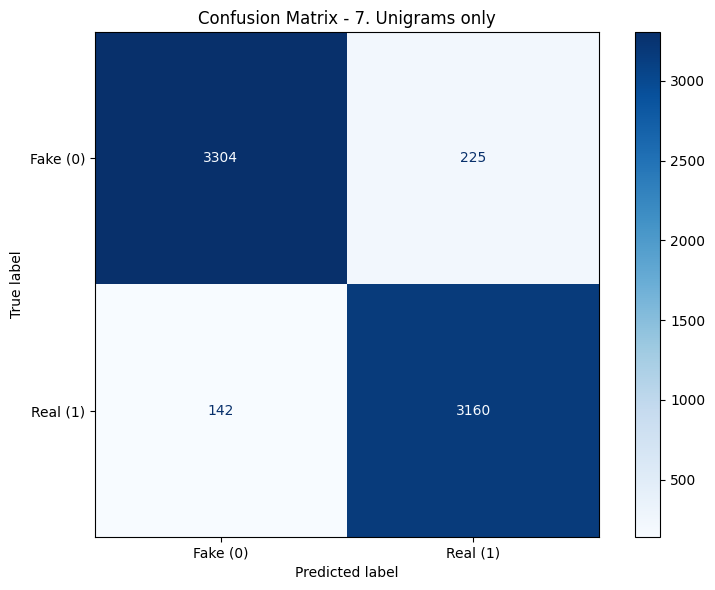

In [11]:
# Confusion matrix for best model
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    best_result['y_test'], 
    best_result['y_pred'],
    display_labels=['Fake (0)', 'Real (1)'],
    cmap='Blues',
    ax=ax
)
ax.set_title(f"Confusion Matrix - {best_result['config']}")
plt.tight_layout()
plt.show()

In [12]:
# Top predictive words for best model
feature_names = best_result['vectorizer'].get_feature_names_out()
coefs = best_result['model'].coef_[0]

# Get top features for each class
top_real_idx = np.argsort(coefs)[-15:]  # Highest coefs = Real (1)
top_fake_idx = np.argsort(coefs)[:15]   # Lowest coefs = Fake (0)

print("\nTop 15 REAL news indicators (positive coefficients):")
print("-" * 40)
for i in reversed(top_real_idx):
    print(f"  {feature_names[i]:25} {coefs[i]:+.3f}")

print("\nTop 15 FAKE news indicators (negative coefficients):")
print("-" * 40)
for i in top_fake_idx:
    print(f"  {feature_names[i]:25} {coefs[i]:+.3f}")


Top 15 REAL news indicators (positive coefficients):
----------------------------------------
  says                      +9.097
  us                        +8.068
  factbox                   +6.369
  house                     +4.299
  china                     +3.601
  talks                     +3.516
  pm                        +3.489
  urges                     +3.485
  probe                     +3.351
  eu                        +3.271
  senate                    +3.262
  tax                       +3.145
  south                     +3.083
  brexit                    +3.071
  lawmakers                 +2.997

Top 15 FAKE news indicators (negative coefficients):
----------------------------------------
  video                     -15.256
  breaking                  -8.111
  just                      -7.190
  the                       -7.187
  gop                       -6.769
  hillary                   -6.359
  is                        -4.527
  his                       -4.236
  hi

---
## 8. Save Best Model Configuration

In [13]:
# Store best model and vectorizer for later use
best_model = best_result['model']
best_vectorizer = best_result['vectorizer']
best_preprocess_params = best_result['preprocess_params']

print("Best model components saved to variables:")
print("  - best_model (LogisticRegression)")
print("  - best_vectorizer (TfidfVectorizer)")
print("  - best_preprocess_params (dict)")
print(f"\nPreprocessing params: {best_preprocess_params}")

Best model components saved to variables:
  - best_model (LogisticRegression)
  - best_vectorizer (TfidfVectorizer)
  - best_preprocess_params (dict)

Preprocessing params: {'fix_encoding': True, 'remove_punctuation': True, 'remove_stopwords': False, 'use_stemming': False, 'use_lemmatization': False}


---
## 9. Generate Predictions on Test Data

Load the test file (labels are placeholder '2'), apply the same preprocessing, and replace with predictions (0 or 1).

In [14]:
# Load test data
# File has placeholder label '2' which we will replace with predictions
test_file = 'testing_data_lowercase_nolabels.csv'

df_test = pd.read_csv(test_file, sep='\t', header=None, names=['label', 'title'])
print(f"Test data shape: {df_test.shape}")
print(f"\nOriginal labels (placeholder): {df_test['label'].unique()}")
print(f"\nFirst few rows:")
df_test.head()

Test data shape: (9984, 2)

Original labels (placeholder): <StringArray>
['2', '﻿0']
Length: 2, dtype: str

First few rows:


,label,title
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


In [15]:
# Apply the SAME preprocessing as the best model
df_test['title_processed'] = df_test['title'].apply(
    lambda x: preprocess_text(x, **best_preprocess_params)
)

print("Preprocessing applied.")
print(f"\nSample processed titles:")
for i in range(3):
    print(f"  Original:  {df_test['title'].iloc[i][:60]}...")
    print(f"  Processed: {df_test['title_processed'].iloc[i][:60]}...")
    print()

Preprocessing applied.

Sample processed titles:
  Original:  copycat muslim terrorist arrested with assault weapons...
  Processed: copycat muslim terrorist arrested with assault weapons...

  Original:  wow! chicago protester caught on camera admits violent activ...
  Processed: wow chicago protester caught on camera admits violent activi...

  Original:  germany's fdp look to fill schaeuble's big shoes...
  Processed: germanys fdp look to fill schaeubles big shoes...



In [16]:
# Vectorize using the SAME vectorizer (fitted on training data)
X_test_tfidf = best_vectorizer.transform(df_test['title_processed'])
print(f"Vectorized test data shape: {X_test_tfidf.shape}")

Vectorized test data shape: (9984, 12120)


In [17]:
# Generate predictions
predictions = best_model.predict(X_test_tfidf)

print(f"Predictions generated: {len(predictions)}")
print(f"\nPrediction distribution:")
print(f"  Fake (0): {sum(predictions == 0)}")
print(f"  Real (1): {sum(predictions == 1)}")

Predictions generated: 9984

Prediction distribution:
  Fake (0): 4610
  Real (1): 5374


In [18]:
# Create output file - replace placeholder '2' with predictions (0 or 1)
df_output = df_test[['title']].copy()
df_output.insert(0, 'label', predictions)  # Replace '2' with actual predictions

print("Output dataframe (label 2 replaced with predictions):")
print(f"Labels now: {df_output['label'].unique()}")
df_output.head(10)

Output dataframe (label 2 replaced with predictions):
Labels now: [0 1]


,label,title
0,0,copycat muslim terrorist arrested with assault...
1,0,wow! chicago protester caught on camera admits...
2,1,germany's fdp look to fill schaeuble's big shoes
3,0,mi school sends welcome back packet warning ki...
4,1,u.n. seeks 'massive' aid boost amid rohingya '...
5,0,did oprah just leave ‚nasty‚ hillary wishing s...
6,1,france's macron says his job not 'cool' cites ...
7,0,flashback: chilling ‚60 minutes‚ interview wit...
8,1,spanish foreign ministry says to expel north k...
9,1,trump says cuba 'did some bad things' aimed at...


In [19]:
# Save to CSV - filename indicates Logistic Regression model
output_file = 'testing_data_predictions_LR.csv'

df_output.to_csv(output_file, sep='\t', header=False, index=False)

print(f"Predictions saved to: {output_file}")
print(f"\nFile format: tab-separated, no header, columns: [label, title]")
print(f"Labels: 0 = Fake, 1 = Real")

Predictions saved to: testing_data_predictions_LR.csv

File format: tab-separated, no header, columns: [label, title]
Labels: 0 = Fake, 1 = Real


In [20]:
# Verify the output file
print("Verifying output file...")
df_verify = pd.read_csv(output_file, sep='\t', header=None, names=['label', 'title'])
print(f"\nRows: {len(df_verify)}")
print(f"Labels in output: {sorted(df_verify['label'].unique())}")
print(f"\nLabel distribution:")
print(df_verify['label'].value_counts())
print(f"\nFirst 5 rows:")
print(df_verify.head())

Verifying output file...

Rows: 9984
Labels in output: [np.int64(0), np.int64(1)]

Label distribution:
label
1    5374
0    4610
Name: count, dtype: int64

First 5 rows:
   label                                              title
0      0  copycat muslim terrorist arrested with assault...
1      0  wow! chicago protester caught on camera admits...
2      1   germany's fdp look to fill schaeuble's big shoes
3      0  mi school sends welcome back packet warning ki...
4      1  u.n. seeks 'massive' aid boost amid rohingya '...


---
## Summary

**Best Configuration:** See results above

**Model Used:** Logistic Regression

**Files Generated:**
- `testing_data_predictions_LR.csv` - Predictions with label 2 replaced by 0 (Fake) or 1 (Real)

**Estimated Accuracy:** Based on test set performance of the best model